# EGFR data curation

**EGFR (Epidermal Growth Factor Receptor) kinase** is a type of receptor tyrosine kinase that plays a significant role in cell growth, proliferation, and survival. Mutations or overexpression of EGFR have been associated with various diseases, particularly cancer.

- **EGFR Wild type**:  Targeting wild-type EGFR with small-molecule inhibitors, such as erlotinib, is an ongoing area of research in the treatment of glioblastoma. While early findings are promising, the complexity of glioblastoma biology presents challenges that require further investigation to improve treatment outcomes for patients.
- **EGFR L858R:** While EGFR TKIs initially demonstrate impressive responses in NSCLC patients with the L858R mutation, resistance to these drugs can develop over time. However, newer generations of EGFR TKIs, like osimertinib, have been developed to target these resistant mutations.

**Published EGFR datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis. [ref]

**Description of readout:**
- **Readouts**: `EGFR_(L858R_mutant)`, `EGFR`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

<a id="curation"></a>
# EGFR data curation

**Data pre-processing**

**Step 1** - Curate the chemistry information
  - Clean the molecules by perform molecule sanitization and fix, standardization molecules, salts/solvents removals.
  - Detect the stereochemistry information in the molecules. Such as undefined stereo centers and information. It's crucial in the case of the activity cliff among the stereoisomers.

<br>

**Step 2** - Curate the measured values
  - Identify the compounds which have multiple measures in the dataset. The identification of the repeated molecules is defined by `datamol.hash_mol` including stereochemistry information.
  - Verify the data resource and remove the dubious data points which are significant different or in different classes in case of categorical data. Compute the average of the rest of the duplicated molecules.
  - Detect potential outliers of the dataset. Verify the data resource and remove the dubious data points.
  - Convert the continuous values based on provided threshold values to classification tasks.
  - Detect activity cliff between the stereoisomers. Those isomers and their bioactivity values can be removed/masked from dataset if the downstream molecule representation is not able to differentiate the stereoisomers.

<br>

**Step 3** - Visual inspection
  - Access molecular diversity and distribution in the chemical space. This can guide the decision on which splitting approach to employ. 
  - Visualize the distribution of bioactivity values. It's useful to exam whether it's meaningful to convert to classification task.
  - Check molecules which contain undisered characters.

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
import polaris
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
# load data
data = pd.read_parquet(
    "gs://polaris-private/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parquet"
)
data.shape

(364, 1129)

In [3]:
# Define data column names
data_cols = ['EGFR_(L858R_mutant)', 'EGFR']
mol_col = "smiles"
data = data[[mol_col] + data_cols][data[data_cols].notna().any(axis=1)]

In [4]:
data.describe()[data_cols]

,EGFR_(L858R_mutant),EGFR
count,364.000000,363.000000
mean,19.391113,16.777479
std,27.327321,26.539644
min,-5.940000,-20.030000
25%,2.610000,2.605000
50%,6.525000,5.590000
75%,22.255000,11.875000
max,101.510000,98.050000


In [5]:
for data_col in data_cols: 
    display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_90621/1691884317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())


EGFR_(L858R_mutant)
(0, 70]      293
(70, 75]       6
(75, 80]       5
(80, 90]      11
(90, 100]     15
Name: EGFR_(L858R_mutant), dtype: int64

EGFR
(0, 70]      303
(70, 75]       3
(75, 80]      15
(80, 90]      19
(90, 100]      6
Name: EGFR, dtype: int64

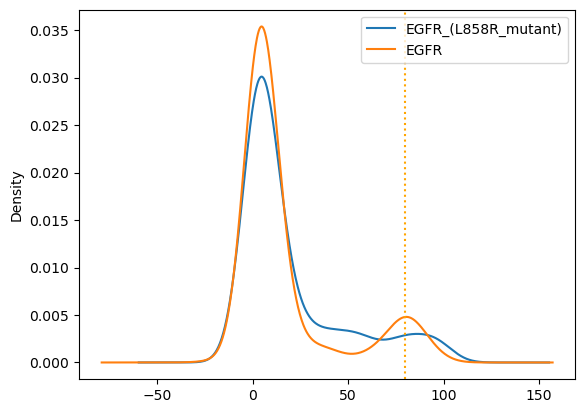

In [6]:
fig = data[data_cols].plot.kde()
plt.axvline(x=80, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [7]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
# However, due to the number of active compounds and the above distribution
# We can lower the threshold to 80
th = 80
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [8]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

2023-10-18 00:26:36.008 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR_(L858R_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-10-18 00:26:36.010 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future 

In [9]:
for col in data_cols:
    print(col)
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

EGFR_(L858R_mutant)


,EGFR_(L858R_mutant),EGFR
146,101.51,78.07


EGFR


,EGFR_(L858R_mutant),EGFR
33,80.97,98.05


The curation raised warning for potential outliers from the bioactivity readouts of all EGFR mutants. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

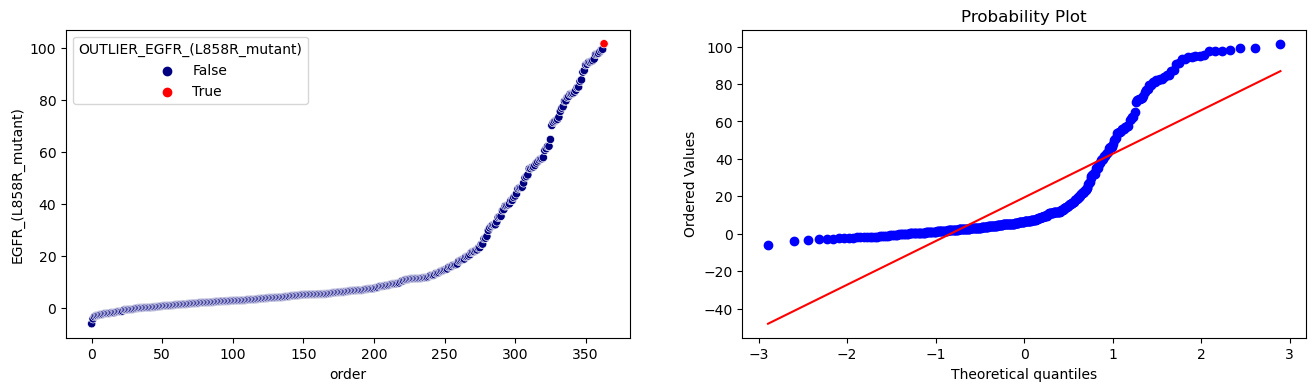

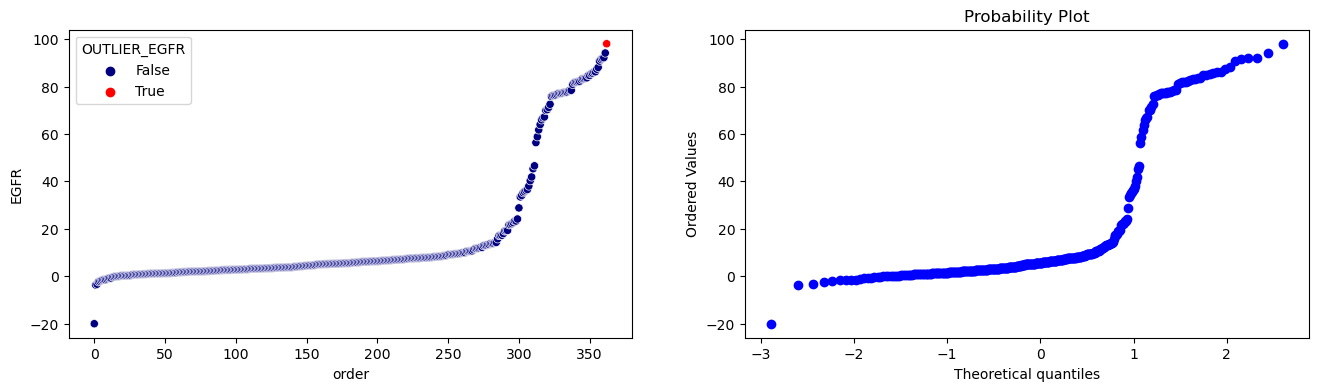

In [10]:
from utils import show_outliers
show_outliers(data=df_full, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Check the compounds with undisered characters

In [11]:
from utils import basic_filter

In [12]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/364 [00:00<?, ?it/s]

In [13]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

There is no compounds which contains undiserable elements.

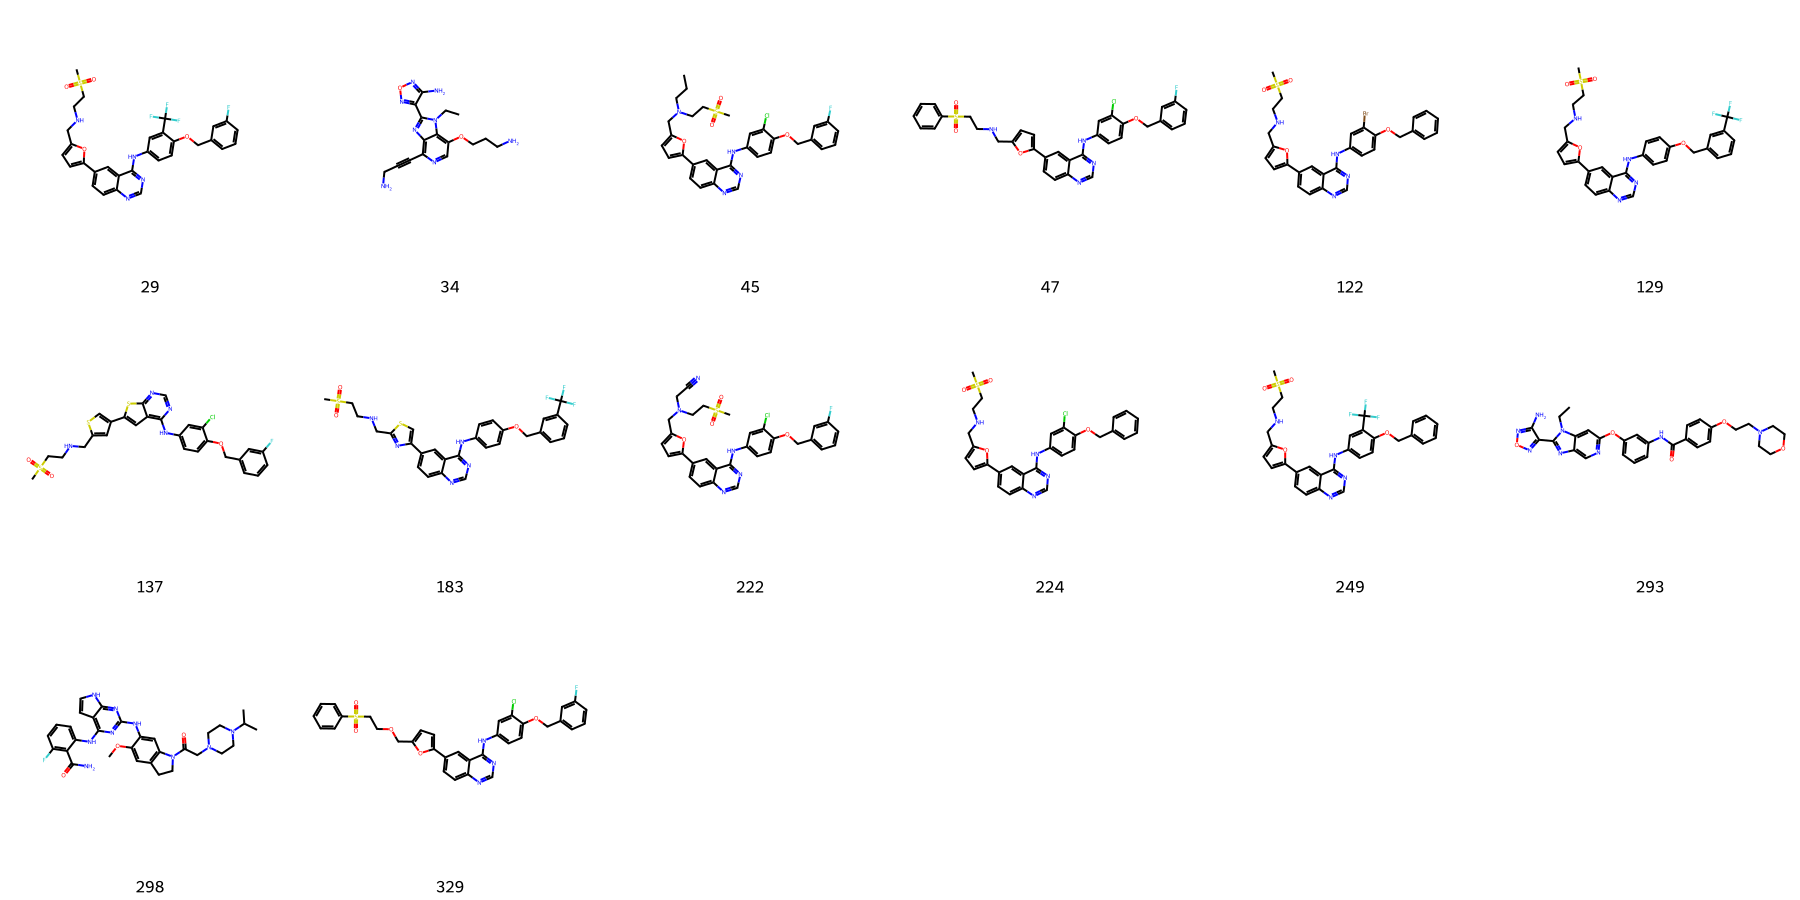

In [14]:
# visualize molecules which don't pass any of the nibr filters.
to_plot = processed_df[~processed_df.pass_any]
to_plot.reset_index(inplace=True)
legends=to_plot['index'].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=6)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From the above suggested molecules, there is no compound which contains striking unwanted substructure or extremely large groups. 

## Chemical space

In [15]:
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]

In [16]:
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]

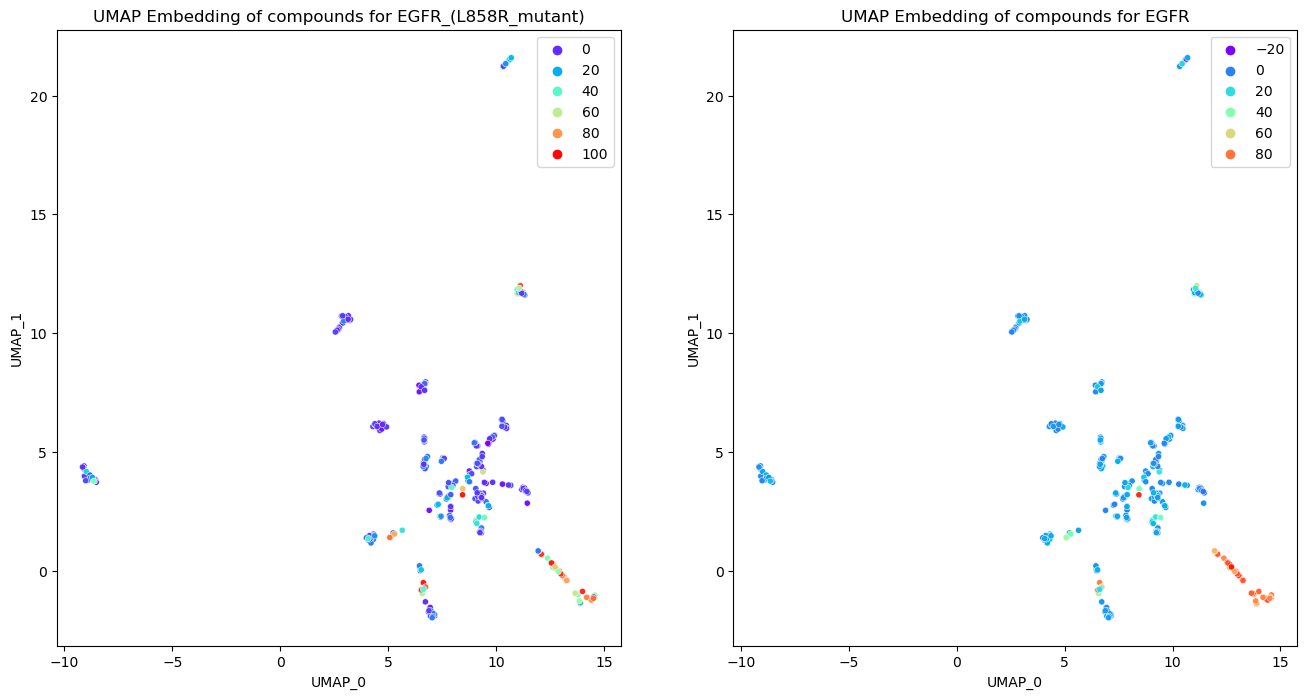

In [17]:
method = "UMAP"

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(data_cols):
    sns.scatterplot(
        data=df_full,
        x="UMAP_0",
        y="UMAP_1",
        palette="rainbow",
        hue=df_full[data_cols[i]].values,
        ax=axes[i],
        s=20,
    )
    axes[i].set_title(f"{method} Embedding of compounds for {col}")

With the above representation, the compounds spread in about 10 large and smaller clusters.  The compounds with higher bioactivity are similarly distributed in three clusters for `EGFR_(L858R_mutant)` and `EGFR wild type`. 
The goal are to 1) optimize the bioactivity % inhibition. 2) discovery of potential hits in new chemical space. Therefore a scaffold based split method is more relevant in this context. 

In [18]:
df_full.drop(columns=["UMAP_0", "UMAP_1"]).to_parquet( "gs://polaris-private/Data/Kinases/EGFR_mutants_curated.parquet", index=False)

## Dataset creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_EGFR_mutants_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [19]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

In [20]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

**Create the EGFR dataset with `polaris.Dataset`** 

In [21]:
# Load data
PATH = 'gs://polaris-private/Data/Kinases/EGFR_mutants_curated.parquet'
table = pd.read_parquet(PATH)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [22]:
table.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)

In [23]:
annotations = {
     'UNIQUE_ID': ColumnAnnotation(description='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(description='Molecule SMILES string'),
     'EGFR_(L858R_mutant)': ColumnAnnotation(description='Percentage of inhibition on EGFR with mutation L858R_mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'L858R_mutant', 'target': 'EGFR'}),
     'EGFR': ColumnAnnotation(description='Percentage of inhibition on EGFR wide type', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'EGFR'}),
     'CLASS_EGFR_(L858R_mutant)': ColumnAnnotation(description='Binarized label based on the percentage of inhibition on EGFR L858R_mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'EGFR_(L858R_mutant)'}),
     'CLASS_EGFR': ColumnAnnotation(description='Binarized label based on the percentage of inhibition on EGFR wide type', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'EGFR'})
}

**Create `Dataset` object**

In [24]:
data_readme = """

**EGFR (Epidermal Growth Factor Receptor) kinase** is a type of receptor tyrosine kinase that plays a significant role in cell growth, proliferation, and survival. Mutations or overexpression of EGFR have been associated with various diseases, particularly cancer.

- **EGFR Wild type**:  Targeting wild-type EGFR with small-molecule inhibitors, such as erlotinib, is an ongoing area of research in the treatment of glioblastoma. While early findings are promising, the complexity of glioblastoma biology presents challenges that require further investigation to improve treatment outcomes for patients.
- **EGFR L858R:** While EGFR TKIs initially demonstrate impressive responses in NSCLC patients with the L858R mutation, resistance to these drugs can develop over time. However, newer generations of EGFR TKIs, like osimertinib, have been developed to target these resistant mutations.

Description of readout:

- Readouts: EGFR_(L858R_mutant), EGFR
- Bioassay readout: Percentage of inhnibition.
- Optimization objective: Higher the more potent.

"""

In [25]:
dataset = Dataset(
    table=table[list(annotations.keys())],
    name="EGFR_mutants",
    description=f"Profile of kinase EGFR, and its mutant EGFR_(L858R_mutant)",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner,
    tags=["Kinase", "Multitask", "HitDiscovery"], 
)

In [26]:
# save the dataset
SAVE_DIR = "gs://polaris-private/Datasets/Kinases/EGFR_mutants"
dataset.to_json(SAVE_DIR)

'gs://polaris-private/Datasets/Kinases/EGFR_mutants/dataset.json'

In [27]:
fs = dm.fs.get_mapper(SAVE_DIR).fs
fs.ls(SAVE_DIR)

['polaris-private/Datasets/Kinases/EGFR_mutants/dataset.json',
 'polaris-private/Datasets/Kinases/EGFR_mutants/table.parquet']

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

**Load existing Dataset object**

In [28]:
dataset = polaris.load_dataset("gs://polaris-private/Datasets/Kinases/EGFR_mutants/dataset.json")

In [29]:
# Visualize all information about the dataset
dataset

{
  "name": "EGFR_mutants",
  "description": "Profile of kinase EGFR, and its mutant EGFR_(L858R_mutant)",
  "tags": [
    "Kinase",
    "Multitask",
    "HitDiscovery"
  ],
  "user_attributes": {},
  "owner": {
    "slug": "polaristest",
    "organization_id": "PolarisTest",
    "user_id": null,
    "owner": "PolarisTest"
  },
  "md5sum": "a436ae7fb4b79e5cafdf4412fff6c9e8",
  "readme": "",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Molecular hash ID. See <datamol.mol.hash_mol>",
      "user_attributes": {}
    },
    "smiles": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Molecule SMILES string",
      "user_attributes": {}
    },
    "EGFR_(L858R_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Percentage of inhibition on EGFR with mutation L858R_mutant",
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "PKIS1",
        "mutation": "L858R_mutant",
        "target": "EGFR"
      }
    },
    "EGFR": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Percentage of inhibition on EGFR wide type",
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
        "mutation": "None",
        "target": "EGFR"
      }
    },
    "CLASS_EGFR_(L858R_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Binarized label based on the percentage of inhibition on EGFR L858R_mutant",
      "user_attributes": {
        "thresholds": "[80]",
        "label_order": "ascending",
        "ref_col": "EGFR_(L858R_mutant)"
      }
    },
    "CLASS_EGFR": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Binarized label based on the percentage of inhibition on EGFR wide type",
      "user_attributes": {
        "thresholds": "[80]",
        "label_order": "ascending",
        "ref_col": "EGFR"
      }
    }
  },
  "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
  "license": null,
  "cache_dir": "/Users/lu.zhu/Library/Caches/polaris/datasets/EGFR_mutants/a436ae7fb4b79e5cafdf4412fff6c9e8"
}

## Create scaffold split for EGFR mutants 

In [30]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit

TEST_SIZE = 0.2
SEED = 111
splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

In [31]:
data_cols = ['EGFR_(L858R_mutant)', 'EGFR']

In [32]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
nums_pos_test = []
TEST_SIZE = 0.2
while flag:
    nums_pos_test = []
    SEED = np.random.randint(1,1000,1)[0]
    SEED = 846
    splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
    scaffold_split = next(splitter.split(X=dataset.table.smiles.values))
    for data_col in data_cols:
        num_pos_test = dataset.table.loc[scaffold_split[1], f"CLASS_{data_col}"].sum()
        nums_pos_test.append(num_pos_test)
    flag = min(nums_pos_test) < 10


In [33]:
print(SEED, nums_pos_test)

846 [11.0, 10.0]


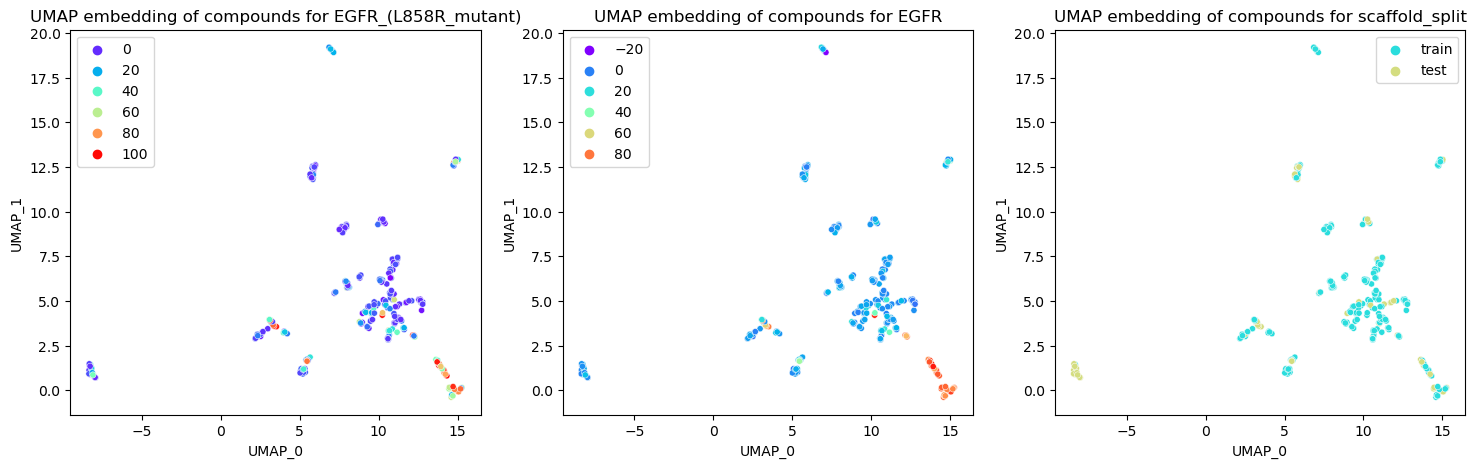

In [34]:
from utils import display_umap
fig = display_umap(df_full, 'smiles', split =scaffold_split, split_name="scaffold_split", data_cols=data_cols)

## Multitask for EGFR endpoints with scaffold split 

In [35]:
benchmark_readme=f"""
**The goal** of this benchmark is to select the best predictive model for 
- Optimization of the bioactivity % inhibition.
- Discovery of potential hits in new chemical space.

Therefore, a scaffold-based splitting approach was applied to ensure training and test sets contain distinct chemical structures while maintaining the diversity of scaffolds.

See more details in the dataset information.  
"""

**Regression**

In [36]:
data_cols = ['EGFR_(L858R_mutant)', 'EGFR']
name ="EGFR_mutants_multitask_reg"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_reg = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="mean_squared_error",
    tags=['Kinase', 'HitDiscovery', 'Selectivity','Regression'], 
    description="Multitask regression benchmark for EGFR wild type and L858R mutant.",
    owner=owner, 
    readme= benchmark_readme
)
path = benchmark_reg.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/EGFR_mutants_multitask_reg/benchmark.json


**Classification**

In [37]:
data_cols = ['CLASS_EGFR', 'CLASS_EGFR_(L858R_mutant)']
name ="EGFR_mutants_multitask_clf"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="accuracy",
    tags=['Kinase', 'HitDiscovery', 'Selectivity', 'Classification'],
    description="Multitask classification benchmark for EGFR wild type and L858R mutant.",
    owner=owner, readme=benchmark_readme
)
path = benchmark_clf.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/EGFR_mutants_multitask_clf/benchmark.json
